In [2]:
# !pip install openai  --upgrade --quiet

# Initiate

In [3]:
import time
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine, euclidean

openai.api_key = os.environ['OPENAI_API_KEY']
np.set_printoptions(precision=3, suppress=True)

REFRESH = False

def get_embedding(text, sleep=0):
    '''Compute GPT3-embedding for a given text string'''
    time.sleep(sleep)
    result = openai.Embedding.create(input=text, model='text-embedding-ada-002')
    return np.array(result.data[0].embedding)

# Get dfs

In [4]:
people = pd.read_csv('./data/people.csv')
messages = pd.read_csv('./data/messages.csv', sep='John_Cena')
images = pd.read_csv('./data/images.csv', sep='John_Cena')

C:\Users\Ansebi\AppData\Local\Temp\ipykernel_13092\599353379.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  messages = pd.read_csv('./data/messages.csv', sep='John_Cena')
C:\Users\Ansebi\AppData\Local\Temp\ipykernel_13092\599353379.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  images = pd.read_csv('./data/images.csv', sep='John_Cena')


In [5]:
df_people = pd.DataFrame([{j[0]:j[1] for j in [i.split(': ') for i in person.replace('\r', '').split('\n')]} for person in list(people.items())[0][1]])

In [6]:
# @title adequate notation
# people_list = []
# for person in list(people.items())[0][1]:
#     person = person.replace('\r', '')
#     person_list = [i.split(': ') for i in person.split('\n')]
#     person_dict = {j[0]: j[1] for j in person_list}
#     people_list.append(person_dict)
# df_people = pd.DataFrame(people_list)

In [7]:
df_people['Likes'] = df_people['Likes'].str.split(', ')
df_people['Dislikes'] = df_people['Dislikes'].str.split(', ')

In [8]:
def glue(row):
    replacement_dict = {'Male': 'man', 'Female': 'woman'}
    row['Gender'] = replacement_dict.get(row['Gender'], 'John Cena')
    return ' '.join(row[['Lifestyle', 'Age', 'Race', 'Gender']].values).lower()

In [9]:
df_people['Description'] = df_people.apply(lambda row: glue(row), axis='columns')

In [10]:
df_people['ID'] = range(len(df_people))

In [11]:
df_people

,Gender,Age,Race,Lifestyle,Likes,Dislikes,Description,ID
0,man,Young Adult,African American,Moderate,"[Sports, Outdoors, Learning, Exercise]","[Homemaking, Design, Relaxing, Arts and Crafts]",moderate young adult african american man,0
1,woman,Adult,Asian,Active,"[Outdoors, Exercise, Sports, Homemaking]","[Arts and Crafts, Design, Games, Relaxing]",active adult asian woman,1
2,man,Senior,Hispanic,Sedentary,"[Relaxing, Homemaking, Indoors, Arts and Crafts]","[Outdoors, Sports, Exercise, Design]",sedentary senior hispanic man,2
3,woman,Young Adult,Asian,Moderate,"[Learning, Design, Arts and Crafts, Games]","[Sports, Outdoors, Homemaking, Relaxing]",moderate young adult asian woman,3
4,man,Adult,White,Active,"[Sports, Outdoors, Exercise, Games]","[Homemaking, Design, Arts and Crafts, Relaxing]",active adult white man,4
5,woman,Middle-aged,Hispanic,Sedentary,"[Relaxing, Homemaking, Indoors, Arts and Crafts]","[Outdoors, Sports, Exercise, Design]",sedentary middle-aged hispanic woman,5
6,man,Senior,White,Moderate,"[Learning, Design, Arts and Crafts, Relaxing]","[Sports, Outdoors, Homemaking, Exercise]",moderate senior white man,6
7,woman,Young Adult,Asian,Active,"[Sports, Outdoors, Exercise, Homemaking]","[Arts and Crafts, Design, Games, Relaxing]",active young adult asian woman,7
8,man,Adult,African American,Sedentary,"[Relaxing, Homemaking, Indoors, Arts and Crafts]","[Outdoors, Sports, Exercise, Design]",sedentary adult african american man,8
9,woman,Middle-aged,Asian,Moderate,"[Learning, Design, Arts and Crafts, Games]","[Sports, Outdoors, Homemaking, Relaxing]",moderate middle-aged asian woman,9


compose the dictionary with embeddings of all the likes and dislikes

likes = set(np.concatenate(df_people.Likes))
dislikes = set(np.concatenate(df_people.Dislikes))

embeddings_dict = {}
for i in likes | dislikes:
    time.sleep(2)
    embeddings_dict[i] = get_embedding(i)

descriptions_embeddings_dict = {}
for i in df_people.Description:
    time.sleep(2)
    descriptions_embeddings_dict[i] = get_embedding(i)

descriptions_embeddings_dict

In [12]:
def get_df_likes_dislikes(
        attr,
        df_people=df_people,
        refresh=REFRESH
        ):
    if not refresh:
        raise Exception('API call aborted. Were you sure? If yes, change REFRESH to True.')
    df = pd.DataFrame()
    for i in df_people[['ID', 'Description', attr]].values:
        for like in i[2]:
            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        [
                            i[0],
                            like.lower(),
                            f'{i[1]} who likes {like.lower()}'
                        ]
                    ).T
                ],
                axis='rows'
            )
    df.reset_index(inplace=True, drop=True)
    df.columns=['ID', 'Activity', 'Description']
    df['Embedding'] = df.Description.apply(lambda x: get_embedding(x))
    return df

In [13]:
def add_activity(df):
    df['Activity'] = np.stack(df.Description.str.split('who likes '))[:, 1]

In [14]:
def normalize(x, overall_min, overall_max):  # currently from -1 to 1 due to negative vectors (we center at 0)
    return 2 * (x - overall_min) / (overall_max - overall_min) - 1

def add_deviation(df):
    # first we find mean vector for an ID
    # only then we find the mean for likes/dislikes
    # thus we prevent individuals having too much likes/dislikes
    # from solely deciding the mean
    mean_vector = df\
    .groupby('ID')\
    .Embedding\
    .apply(lambda x: np.mean(np.stack(x), axis=0))\
    .mean()
    deviation = df.Embedding.apply(lambda x: x - mean_vector)
    df['Deviation'] = deviation
    overall = np.concatenate(df.Deviation)
    overall_min = np.min(overall)
    overall_max = np.max(overall)
    del overall
    norm_dev = df.Deviation.apply(lambda x: normalize(x, overall_min, overall_max))
    df['Norm_Dev'] = norm_dev

In [15]:
preferences_dfs = {}
for likes_dislikes in ['likes', 'dislikes']:
    if REFRESH:
        preferences_dfs[likes_dislikes] = get_df_likes_dislikes(
            likes_dislikes.capitalize(), df_people=df_people
            )
        preferences_dfs[likes_dislikes].to_csv(f'data/{likes_dislikes}.csv', index=False)
        np.save(f'data/{likes_dislikes}', preferences_dfs[likes_dislikes].Embedding)
    else:
        preferences_dfs[likes_dislikes] = pd.read_csv(f'data/{likes_dislikes}.csv')
        preferences_dfs[likes_dislikes].Embedding = np.load(
            f'data/{likes_dislikes}.npy', allow_pickle=True
    )
    add_activity(preferences_dfs[likes_dislikes])
    add_deviation(preferences_dfs[likes_dislikes])

In [16]:
content_dfs = {
    'messages': messages,
    'images': images,
}

In [17]:
for content_type in ['messages', 'images']:
    df = content_dfs[content_type]
    df['Content_ID'] = range(len(df))

    if REFRESH:
        df['Embedding'] = df['content'].apply(get_embedding)
        df.to_csv(f'data/{content_type}_embeddings.csv', index=False)
        np.save(f'data/{content_type}', df.Embedding)
    else:
        df['Embedding'] = np.load(f'data/{content_type}.npy', allow_pickle=True)
    # offset each group by it's center
    emb_center = df['Embedding'].mean()    
    deviation = df.Embedding.apply(lambda emb: emb - emb_center)
    df['Deviation'] = deviation
    
    overall = np.concatenate(df.Deviation)
    overall_min = np.min(overall)
    overall_max = np.max(overall)
    del overall
    norm_dev = df.Deviation.apply(lambda x: normalize(x, overall_min, overall_max))
    df['Norm_Dev'] = norm_dev

# Get distances

In [18]:
euclidean([-1, -1], [1, 1])/(2**0.5)

2.0

In [19]:
cosine([-1, -1], [1, 1])

2.0

In [20]:
def get_cosine(vec_1, vec_2, epsilon=10**-6):
    """
    cosine() is so bad, that it's incapable
    of evaluating [0, 0] to [1, 1] distance
    due to zero division.
    Thus we manually bring it to live here
    """
    vec_1 = [i if i else epsilon for i in vec_1]
    vec_2 = [i if i else epsilon for i in vec_2]
    return cosine(vec_1, vec_2)

In [21]:
def get_distance(vec_1, vec_2):
    """
    intended to work with -1 to 1 normalized vectors
    combines two approaches so that negatives of cosine similarity
    are smoothened as well as the negatives of euclidean alone
    """
    euc = euclidean(vec_1, vec_2)
    cos = get_cosine(vec_1, vec_2)
    # let's scale both distances to [0, 1]
    # since cosine() lies between 0 and 2, halve it    
    cos /= 2
    # now normalize the euclidean distance output
    # larges distances in our case are beteween
    # [-1, -1, ... , -1] and [1, 1, ... , 1]
    # and the value depends on n dimensions
    # so let's consider it
    ones = np.ones(len(vec_1))
    largest_euc = euclidean(-ones, ones)
    euc /= largest_euc    
    dist = euc/2 + euc*cos + cos/2
    # scale dist to [0, 1]
    dist /= 2
    # return euc, cos, dist  # an option for testing the function
    return dist

In [22]:
users = set(df_people.ID)
users

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [23]:
user = 0
user_vec = preferences_dfs['likes'].Norm_Dev[user]
user_activity = preferences_dfs['likes'].Activity[user]
user_activity, user_vec

('sports', array([-0.215, -0.147,  0.222, ..., -0.104, -0.1  ,  0.373]))

In [24]:
message_distances = content_dfs['messages'].Norm_Dev.apply(lambda x: get_distance(x, user_vec))
2 * (message_distances - message_distances.min()) / (message_distances.max() - message_distances.min()) - 1

0    -0.578270
1    -0.254970
2     0.654209
3    -0.031063
4    -0.232658
5    -0.836242
6    -0.609635
7    -1.000000
8    -0.682812
9    -0.818118
10   -0.072274
11   -0.346504
12    0.403642
13   -0.131215
14    0.416898
15    0.329650
16   -0.291280
17   -0.448340
18   -0.235248
19   -0.181300
20    0.233747
21    0.288873
22    0.702827
23    0.225809
24   -0.278210
25    0.895140
26    0.907253
27    0.463770
28    0.169184
29   -0.027674
30    0.862179
31    0.230272
32    0.589889
33    0.234934
34    0.386357
35    0.508308
36    0.315224
37    1.000000
38    0.591318
39    0.640380
Name: Norm_Dev, dtype: float64

In [25]:
normalize(
    message_distances,
    message_distances.min(),
    message_distances.max()
)

0    -0.578270
1    -0.254970
2     0.654209
3    -0.031063
4    -0.232658
5    -0.836242
6    -0.609635
7    -1.000000
8    -0.682812
9    -0.818118
10   -0.072274
11   -0.346504
12    0.403642
13   -0.131215
14    0.416898
15    0.329650
16   -0.291280
17   -0.448340
18   -0.235248
19   -0.181300
20    0.233747
21    0.288873
22    0.702827
23    0.225809
24   -0.278210
25    0.895140
26    0.907253
27    0.463770
28    0.169184
29   -0.027674
30    0.862179
31    0.230272
32    0.589889
33    0.234934
34    0.386357
35    0.508308
36    0.315224
37    1.000000
38    0.591318
39    0.640380
Name: Norm_Dev, dtype: float64

In [26]:
user = 10
count = 0
for entry in preferences_dfs['likes'].query(f'ID == {user}').iterrows():
    entry = entry[1]
    if not count:
        count += 1
        print(f'User ID: {user}')
        print(entry.Description.split('who likes')[0])
    message_distances = messages.Norm_Dev.apply(lambda x: get_distance(x, entry.Norm_Dev))
    message_distances_normalized = normalize(
        message_distances,
        message_distances.min(),
        message_distances.max()
    )
    print()
    print(entry.Activity)
    best_fit = message_distances_normalized.argmin()
    worst_fit = message_distances_normalized.argmax()
    print(f'{best_fit=}', messages.loc[best_fit].content)
    print(f'{worst_fit=}', messages.loc[worst_fit].content)


User ID: 10
active senior african american man 

sports
best_fit=9 Grab your clubs and hit the green! Golfing is a fun way to enjoy the outdoors, socialize with friends, and improve your hand-eye coordination and focus. Fore!
worst_fit=37 Put down the phone and pick up some decor! Home decorating is a fun and creative way to express yourself and transform your living space into a cozy and inviting sanctuary. Plus, you'll feel proud of your beautiful and personalized home!

outdoors
best_fit=1 Take a break from your screen and hit the trails! Hiking is a great way to explore nature, get some exercise, and clear your mind. Don't forget to bring some snacks and water!
worst_fit=37 Put down the phone and pick up some decor! Home decorating is a fun and creative way to express yourself and transform your living space into a cozy and inviting sanctuary. Plus, you'll feel proud of your beautiful and personalized home!

exercise
best_fit=4 Step away from your screen and take a walk outside. Wa

In [27]:
entry

ID                                                            10
Description    active senior african american man who likes g...
Embedding      [-0.015264001674950123, -0.030528003349900246,...
Activity                                                   games
Deviation      [-0.006749332282197429, -0.024203352751101193,...
Norm_Dev       [-0.23292488811247625, -0.6890914738219113, -0...
Name: 43, dtype: object

In [28]:
# likes_weight = 1
# dislikes_weight = 1
# preference_distances_by_user = {}
# preference_distances_df = pd.DataFrame()
# for user in users:
#     preference_distances_by_user[user] = {}
#     for content_type in ['messages', 'images']:
#         preference_distances_by_user[user][content_type] = {}
#         for content_entry in content_dfs[content_type].iterrows():
#             content_entry = content_entry[1]
#             preference_distances_by_user[user][content_type][content_entry.Content_ID] = {}
#             for likes_dislikes in ['likes', 'dislikes']:
#                 preference_distances_by_user[user][content_type][content_entry.Content_ID][likes_dislikes] = []
#                 for user_pref_entry in preferences_dfs[likes_dislikes].query(f'ID == {user}').iterrows():
#                     user_pref_entry = user_pref_entry[1]
#                     preference_distance = get_distance(content_entry.Norm_Dev, user_pref_entry.Norm_Dev)
#                     preference_distances_by_user[user][content_type][content_entry.Content_ID][likes_dislikes].append(preference_distance)
#                     print(f'{user=} {content_type} Content_ID={content_entry.Content_ID} {likes_dislikes} {preference_distance}')
#                     distance_df_entry = {
#                         'User_ID': user,
#                         'Content_Type': content_type,
#                         'Content_ID': content_entry.Content_ID,
#                         'Attitude': likes_dislikes,
#                         'Activity': user_pref_entry.Activity,
#                         'Preference_Distance': preference_distance
#                     }
#                     preference_distances_df = pd.concat([preference_distances_df, pd.DataFrame(distance_df_entry, index=[0])])
#             mean_like_distance = np.mean(preference_distances_by_user[user][content_type][content_entry.Content_ID]['likes'])
#             min_dislike_distance =  np.min(preference_distances_by_user[user][content_type][content_entry.Content_ID]['dislikes'])
#             preference_distances_by_user[user][content_type][content_entry.Content_ID]['Preference_Distance'] = mean_like_distance - min_dislike_distance
# preference_distances_df.reset_index(drop=True, inplace=True)

In [29]:
# @title Version with overall distance df
def get_preference_distances_V2_overall():
    likes_weight = 1
    dislikes_weight = 1
    preference_distances_by_user = {}
    preference_distances_df = pd.DataFrame()
    for user in users:
        preference_distances_by_user[user] = {}
        for content_type in ['messages', 'images']:
            preference_distances_by_user[user][content_type] = {}
            for content_entry in content_dfs[content_type].iterrows():
                content_entry = content_entry[1]
                preference_distances_by_user[user][content_type][content_entry.Content_ID] = {}
                for likes_dislikes in ['likes', 'dislikes']:
                    preference_distances_by_user[user][content_type][content_entry.Content_ID][likes_dislikes] = []
                    for user_pref_entry in preferences_dfs[likes_dislikes].query(f'ID == {user}').iterrows():
                        user_pref_entry = user_pref_entry[1]
                        preference_distance = get_distance(content_entry.Norm_Dev, user_pref_entry.Norm_Dev)
                        preference_distances_by_user[user][content_type][content_entry.Content_ID][likes_dislikes].append(preference_distance)
                        # print(f'{user=} {content_type} Content_ID={content_entry.Content_ID} {likes_dislikes} {preference_distance}')
                mean_like_distance = np.mean(preference_distances_by_user[user][content_type][content_entry.Content_ID]['likes'])
                min_dislike_distance =  np.min(preference_distances_by_user[user][content_type][content_entry.Content_ID]['dislikes'])
                overall_preference_distance = mean_like_distance - min_dislike_distance
                preference_distances_by_user[user][content_type][content_entry.Content_ID]['Preference_Distance'] = overall_preference_distance
                distance_df_entry = {
                    'User_ID': user,
                    'Content_Type': content_type,
                    'Content_ID': content_entry.Content_ID,
                    'Preference_Distance': overall_preference_distance
                }
                preference_distances_df = pd.concat([preference_distances_df, pd.DataFrame(distance_df_entry, index=[0])])
    preference_distances_df.reset_index(drop=True, inplace=True)
    return preference_distances_df, preference_distances_by_user

# Distance calculation showcases

the opposite corner is opposite all the time, regardless of n dims

In [30]:
get_distance([0], [1])

0.125

In [31]:
get_distance([0,0], [1,1])

0.125

In [32]:
get_distance([1,1,1], [1,1,1])  # read: vectors are the same. TRUE

0.0

In [33]:
get_distance([0,0,0], [0,0,0])  # read: vectors are the same. TRUE

0.0

In [34]:
get_distance([1,1,1], [1,1,1])  # read: vectors are the same. TRUE
# compare against: dot product

0.0

In [35]:
get_distance([-1,-1,-1], [1,1,1]) # read: vectors are the MOST different. TRUE
# compare against: dot product (False), eucledian (uninterpretable)

1.0

In [36]:
np.dot([0,0,0], [0,0,0])  # read: they are the same. TRUE

0

In [37]:
np.dot([0,0,0], [1,1,1])  # read: they are the same. FALSE

0

In [38]:
np.dot([1,1,1], [1,1,1])  # read: they are different. FALSE

3

In [39]:
np.dot([-1,-1,-1], [1,1,1])  # read: they are super-close. FALSE

-3

Being on the farthest corner is evaluated differently for different n-dims

In [40]:
euclidean([0], [1])

1.0

In [41]:
euclidean([0,0], [1,1])

1.4142135623730951

In [42]:
euclidean([0,0,0], [1,1,1])

1.7320508075688772

In [43]:
euclidean([0,0,0,0], [1,1,1,1])

2.0

In [44]:
# Pairwise difference = 0.2
# See the opposing vectors:
euclidean([0.1,0.1,0.1], [-0.1,-0.1,-0.1])

0.3464101615137755

In [45]:
# Pairwise difference = 0.2
# See the identically oriented vectors:
euclidean([0.1,0.1,0.1], [0.3,0.3,0.3])


0.3464101615137754

read: the OPPOSING things are no different from identically inclined things. FALSE <br>
E.g. enjoying swimming more than you do is equivalent to hating swiming as much as you love it. FALSE

In [46]:
# Pairwise difference = 0.2
# See the opposing vectors:
get_distance([0.1,0.1,0.1], [-0.1,-0.1,-0.1])

0.325

In [47]:
# Pairwise difference = 0.2
# See the identically oriented vectors:
get_distance([0.1,0.1,0.1], [0.3,0.3,0.3])


0.025000000000000033

read: co-oriented things are less far apart than those opposing each other. TRUE<br>
compare against: dot product (opposite from being correct), euclidean (indifferent to the case)

In [48]:
e = 10**-9  # approaches ZERO
cosine([e,e,e], [1,1,1])  # read: ZERO and MAX are the same. FALSE

0

In [49]:
cosine([-e,-e,-e], [e,e,e])  # read: ZERO and ZERO are super-different. FALSE

2.0

In [50]:
e = 10**-9  # approaches ZERO
get_distance([-e,-e,-e], [e,e,e])  # read: ZERO and ZERO are NOT super-different. TRUE
# closer to being similar
# compare against: cosine

0.25000000075

In [51]:
get_distance([-0.5,-0.5,-0.5], [0.5,0.5,0.5])
# read: opposite vec with half magnitude is closer to the half of being farthest apart. TRUE
# compare against: cosine

0.625

In [52]:
cosine([0,0,0], [1,1,1])  # does not work by default

c:\Programs\Python\Python311\Lib\site-packages\scipy\spatial\distance.py:622: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


0

In [53]:
#requires replacement of zeros by an arbitrary small epsilon value:
get_cosine([0,0,0], [1,1,1], epsilon=10**-6)

0

In [54]:
np.dot([0.1,0.1,0.1], [-0.1,-0.1,-0.1])

-0.030000000000000006

In [55]:
np.dot([1,1,1], [-1,-1,-1])

-3

# Continue: get distances

In [56]:
# @title Version with granular distances per user's instance
def get_preference_distances_V3_granular():
    likes_weight = 1
    dislikes_weight = 1
    preference_distances_by_user = {}
    preference_distances_df = pd.DataFrame()
    for user in users:
        preference_distances_by_user[user] = {}
        for content_type in ['messages', 'images']:
            preference_distances_by_user[user][content_type] = {}
            for content_entry in content_dfs[content_type].iterrows():
                content_entry = content_entry[1]
                preference_distances_by_user[user][content_type][content_entry.Content_ID] = {}
                for likes_dislikes in ['likes', 'dislikes']:
                    preference_distances_by_user[user][content_type][content_entry.Content_ID][likes_dislikes] = {}
                    for user_pref_entry in preferences_dfs[likes_dislikes].query(f'ID == {user}').iterrows():
                        user_pref_entry = user_pref_entry[1]
                        preference_distance = get_distance(content_entry.Norm_Dev, user_pref_entry.Norm_Dev)
                        preference_distances_by_user[user][content_type][content_entry.Content_ID][likes_dislikes][user_pref_entry.Activity] = preference_distance
                        # print(f'{user=} {content_type} Content_ID={content_entry.Content_ID} {likes_dislikes} {user_pref_entry.Activity} {preference_distance}')
                        distance_df_entry = {
                            'User_ID': user,
                            'Content_Type': content_type,
                            'Content_ID': content_entry.Content_ID,
                            'Attitude': likes_dislikes,
                            'Activity': user_pref_entry.Activity,
                            'Distance_to_this_preference': preference_distance
                        }
                        preference_distances_df = pd.concat([preference_distances_df, pd.DataFrame(distance_df_entry, index=[0])])
    preference_distances_df.reset_index(drop=True, inplace=True)
    return preference_distances_df, preference_distances_by_user

In [57]:
preference_distances_df, preference_distances_by_user = get_preference_distances_V3_granular()
# mean_like_distance = np.mean(preference_distances_by_user[user][content_type][content_entry.Content_ID]['likes'])
min_dislike_distance =  np.min(list(preference_distances_by_user[user][content_type][0]['dislikes'].values()))
# preference_distances_by_user[user][content_type][content_entry.Content_ID]['Distance_to_this_preference'] = mean_like_distance - min_dislike_distance

In [58]:
for user_id, group in preference_distances_df.groupby(['User_ID', 'Content_Type']):
    print(user_id)
    display(group)
    break

(0, 'images')


,User_ID,Content_Type,Content_ID,Attitude,Activity,Distance_to_this_preference
320,0,images,0,likes,sports,0.191808
321,0,images,0,likes,outdoors,0.196748
322,0,images,0,likes,learning,0.192176
323,0,images,0,likes,exercise,0.201985
324,0,images,0,dislikes,homemaking,0.201087
...,...,...,...,...,...,...
587,0,images,33,likes,exercise,0.184707
588,0,images,33,dislikes,homemaking,0.145990
589,0,images,33,dislikes,design,0.186591
590,0,images,33,dislikes,relaxing,0.185923


In [59]:
class V2:
    def __init__(self):
        self.preference_distances_df, self.preference_distances_by_user = get_preference_distances_V2_overall()

    def print_user_results(
            self,
            user: int,
            content_type: str,
            n_items: int = 5
        ):
        """
        user (int): User_ID

        content_type (str): either 'messages' or 'images'

        n_items: top N messages/images,
        set 1 to show the best/worst options,
        default = 5 (for number of fingers in human to count with)
        """
        print(people.loc[user].content)
        
        dist_data = self.preference_distances_by_user[user][content_type].items()
        pref_dist_list = [(content_id, i['Preference_Distance']) for (content_id, i) in dist_data]
        sorted_content_ids = sorted(
            pref_dist_list,
            key=lambda x: x[1]
            )

        print(f'\nTop {n_items} {content_type}:')
        for n, (content_id, pref_dist) in enumerate(sorted_content_ids[:n_items]):
            content = content_dfs[content_type]\
                .query(f'Content_ID == {content_id}')\
                    .content\
                        .values[0]
            print(f'{n+1}. {content}')

        print(f'\nBottom {n_items} {content_type}:')
        for n, (content_id, pref_dist) in enumerate(sorted_content_ids[-n_items:][::-1]):
            content = content_dfs[content_type]\
                .query(f'Content_ID == {content_id}')\
                    .content\
                        .values[0]
            print(f'{n+1}. {content}')

In [60]:
V2_instance = V2()

In [61]:
V2_instance.print_user_results(
    user=10,
    content_type='messages',
    n_items=5
    )

Gender: Male
Age: Senior
Race: African American
Lifestyle: Active
Likes: Sports, Outdoors, Exercise, Games
Dislikes: Homemaking, Design, Arts and Crafts, Relaxing

Top 5 messages:
1. Grab your clubs and hit the green! Golfing is a fun way to enjoy the outdoors, socialize with friends, and improve your hand-eye coordination and focus. Fore!
2. Hop on your bike and feel the wind in your hair! Biking is a fun and eco-friendly way to explore your surroundings, get some exercise, and enjoy the outdoors. Don't forget your helmet!
3. Put on your running shoes and hit the pavement! Jogging is a great way to improve your cardiovascular health, burn calories, and reduce stress. Start slow and steady, and work your way up!
4. Pick up some weights and feel the burn! Weightlifting is a great way to build muscle, boost your metabolism, and feel more confident in your body. You got this!
5. Strap on your roller skates and roll into some fun! Roller skating is a great way to improve your balance, coor

In [62]:
V2_instance.print_user_results(
    user=10,
    content_type='images',
    n_items=5
)

Gender: Male
Age: Senior
Race: African American
Lifestyle: Active
Likes: Sports, Outdoors, Exercise, Games
Dislikes: Homemaking, Design, Arts and Crafts, Relaxing

Top 5 images:
1. Senior hispanic man playing a game of cards in the park.
2. Person shuffling a deck of playing cards.
3. Young adult African American man walking his dog in the park.
4. Senior white woman biking in the park and looking towards the sky.
5. Senior white man wearing a coat and holding a book while walking outdoors.

Bottom 5 images:
1. Young adult white woman dancing and cleaning the house.
2. Woman placing a cutting board into the kitchen cupboard.
3. Adult white woman sitting at a desk and painting.
4. Person sketching flowers in a notepad.
5. Adult white woman rolling dough in the kitchen and smiling.


In [63]:
# # generating the best recommendation for each user via grouped df of distances

# mean_like_dists = preference_distances_df.query("Attitude == 'likes'")\
#     .drop(columns=['Activity', 'Attitude'])\
#         .groupby(
#             [
#                 'User_ID',
#                 'Content_Type',
#                 'Content_ID'
#             ]
#         ).mean()['Preference_Distance']
# min_dislike_dists = preference_distances_df.query("Attitude == 'dislikes'")\
#     .drop(columns=['Activity', 'Attitude'])\
#         .groupby(
#             [
#                 'User_ID',
#                 'Content_Type',
#                 'Content_ID'
#             ]
#         ).min()['Preference_Distance']
# grouped = preference_distances_df\
#     .drop(columns=['Activity', 'Attitude'])\
#         .groupby(
#             [
#                 'User_ID',
#                 'Content_Type',
#                 'Content_ID'
#             ]
#         ).count()
# grouped['Preference_Distance'] = mean_like_dists - min_dislike_dists
# min_dist_indexes = grouped.groupby(['User_ID', 'Content_Type'])['Preference_Distance'].idxmin()
# grouped.loc[min_dist_indexes]

In [64]:
preference_distances_df_copy = preference_distances_df.copy()

In [65]:
for name, group in preference_distances_df.groupby(['User_ID', 'Content_Type']):
    pref_dist = group.Distance_to_this_preference
    min_ = pref_dist.min()
    max_ = pref_dist.max()
    pref_dist = (pref_dist - min_) / (max_ - min_)
    group.Distance_to_this_preference = pref_dist
    display(group)
    break

,User_ID,Content_Type,Content_ID,Attitude,Activity,Distance_to_this_preference
320,0,images,0,likes,sports,0.479498
321,0,images,0,likes,outdoors,0.508695
322,0,images,0,likes,learning,0.481672
323,0,images,0,likes,exercise,0.539645
324,0,images,0,dislikes,homemaking,0.534335
...,...,...,...,...,...,...
587,0,images,33,likes,exercise,0.437529
588,0,images,33,dislikes,homemaking,0.208709
589,0,images,33,dislikes,design,0.448663
590,0,images,33,dislikes,relaxing,0.444715


In [66]:
def get_message_image_distances():
    message_image_distances_dict = {}
    for message_row in content_dfs['messages'].iterrows():
        message_id = message_row[1]['Content_ID']
        message_norm_dev = message_row[1].Norm_Dev
        message_image_distances_dict[message_id] = {}
        for image_row in content_dfs['images'].iterrows():
            image_norm_dev = image_row[1].Norm_Dev
            image_id = image_row[1]['Content_ID']
            dist = get_distance(message_norm_dev, image_norm_dev)
            message_image_distances_dict[message_id][image_id] = dist
    return message_image_distances_dict

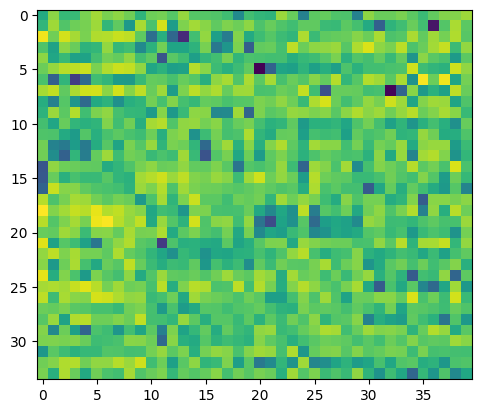

In [67]:
message_image_distances_dict = get_message_image_distances()
plt.imshow(pd.DataFrame(message_image_distances_dict))

In [67]:
triangular_distances_by_user = {}
for user_id, data in preference_distances_by_user.items():
    triangular_distances_by_user[user_id] = {}
    message_pref_dict = {m_id: m_data['Preference_Distance'] for m_id, m_data in data['messages'].items()}
    image_pref_dict = {i_id: i_data['Preference_Distance'] for i_id, i_data in data['images'].items()}
    break


KeyError: 'Preference_Distance'

In [87]:
min(message_pref_dict.values())

NameError: name 'message_pref_dict' is not defined

# ________________